# Inverse kinematics of a robot using python and ROS

Self study, based on Robotic Arm: pick and place by Udacity

## DENAVIT-HARTEMBERG and FORWARD KINEMATICS

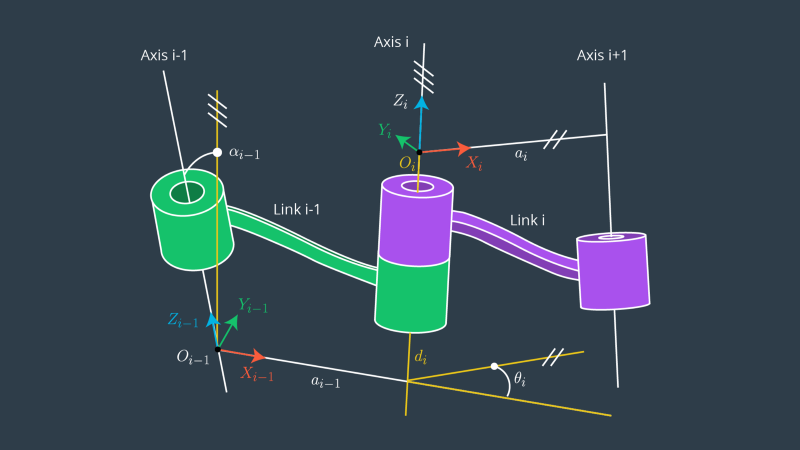

In [1]:
from IPython.display import Image
Image("img/DHParameter.png")

Where:

* $d_i$: Link offset, distance between $X_{i−1}$ and $X_i$, measured along $Z_{i−1}$, *variable in **prismatic** joints*.

* $α_{i−1}$: Angle between $Z_{i−1}$ and $Z_i$, measured along $X_i$.

* $a_{i−1}$: Link length, distance between $Z_{i−1}$ and $Z_i$, measured along $Z_{i−1}$.

* $θ_i$: Joint angle, Angle between $X_{i−1}$ and $X_i$, measured along $Z_i$, *variable in **revolute** joints*.

According to the modified convention, the transform matrix between links $L_i−1$ and $L_i$ is given by the following order of operations:
roation by $α_i−1$ along $X_i−1$, translation by $a_i−1$ along $X_i−1$, rotation by $θ_i$ along $Z_i$, and finally translation by $d_i$ along $Z_i$.

In [2]:
Image("img/eq1.png")

Thus, the matrix of the modified DH parameters becomes:

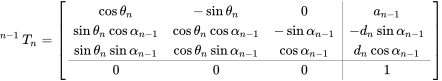

In [3]:
Image("img/eq2.png")

### Example

We can apply this convention to the kuka robotic arm and find out all the required parameters for further analysis. Here is an example given the robot's **joints** in URDF :

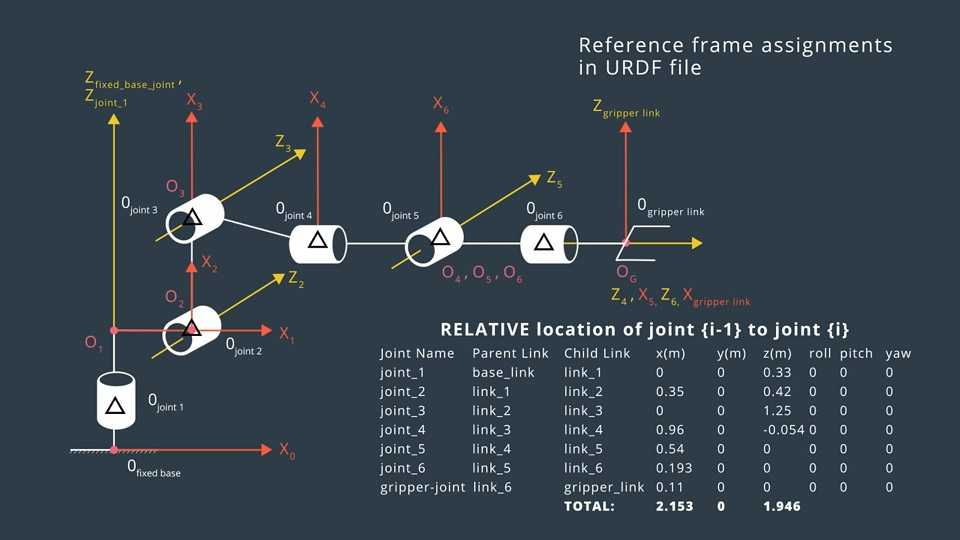

In [4]:
Image("img/urdf_annotation.jpg")

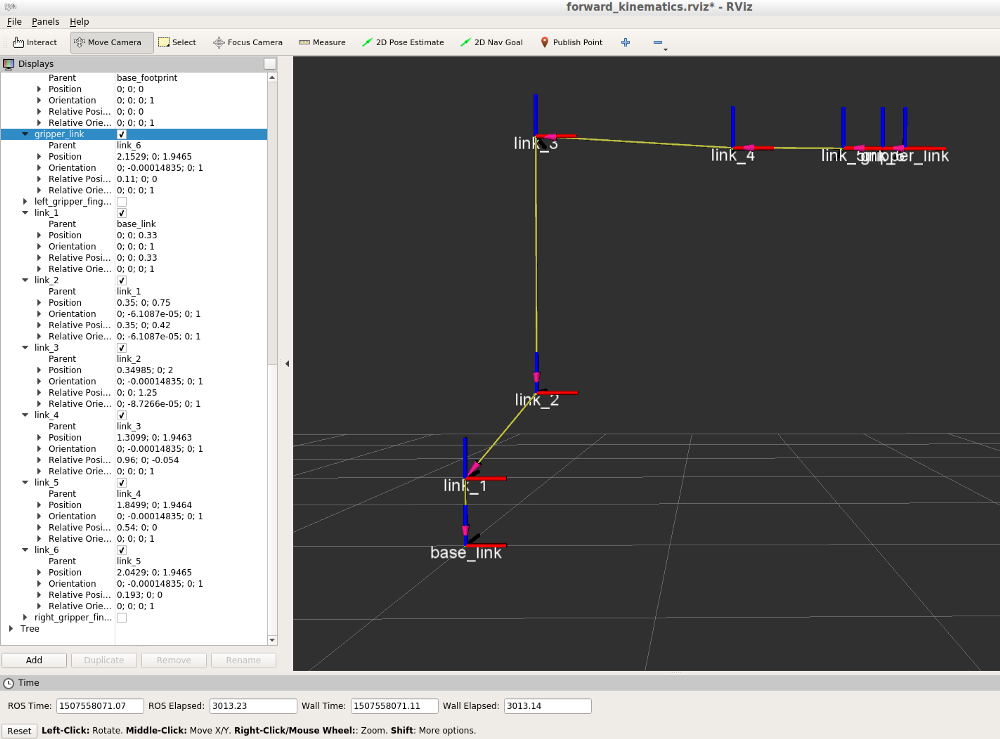

In [5]:
Image("img/rviz_urdf.png")

The modified DH parameters are the following:


|$Joint_i$ |$α_{i−1}$ |$a_{i−1}$ |$d_i$ |$θ_i$ |
---|---|---|---|---|
|1        |0      |0      |0.75 |q1       |
|2        |-pi/2  |0.35   |0    |q2 - pi/2|
|3        |0      |1.25   |0    |q3       |
|4        |-p1/2  |-0.054 |1.50 |q4       |
|5        |pi/2   |0      |0    |q5       |
|6        |-pi/2  |0      |0    |q6       |
|7(G)     |0      |0      |0.3  |0        |

In [6]:
# Create Modified DH parameters
from sympy import *

## Define DH param symbols
d1, d2, d3, d4, d5, d6, d7 = symbols('d1:8')  # link_offset_i
a0, a1, a2, a3, a4, a5, a6 = symbols('a0:7')  # link_length_i
alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6 = symbols('alpha0:7')  # link_twist_i

## Joint angle symbols
q1, q2, q3, q4, q5, q6, q7 = symbols('q1:8') # theta_i

DH = {   alpha0: 0,      a0: 0,      d1: 0.75,    q1: q1,
         alpha1: -pi/2,  a1: 0.35,   d2: 0,       q2: q2-pi/2,
         alpha2: 0,      a2: 1.25,   d3: 0,       q3: q3,
         alpha3: -pi/2,  a3: 0.0536, d4: 1.5014,  q4: q4,
         alpha4: pi/2,   a4: 0,      d5: 0,       q5: q5,
         alpha5: -pi/2,  a5: 0,      d6: 0,       q6: q6,
         alpha6: 0,      a6: 0,      d7: 0.303,   q7: 0}

In [7]:

### Creates Homogeneous Transform Matrix from DH parameters
def homogeneous_transform(q, d, a, alpha):
    
    T = Matrix([[cos(q),            -sin(q),           0,             a          ],
                [ sin(q)*cos(alpha), cos(q)*cos(alpha), -sin(alpha), -sin(alpha)*d],
                [ sin(q)*sin(alpha), cos(q)*sin(alpha),  cos(alpha),  cos(alpha)*d],
                [                 0,                 0,           0,             1]])
    return T

Also, total homogenous transform between base_link and gripper_link can be computed as:
    
$T^G_0=T^1_0∗T^2_1∗T^3_2∗T^4_3∗T^5_4∗T^6_5∗T^G_6$

Individual Transforms can be computed this way:

In [8]:
# Create individual transformation matrices
T0_1 = homogeneous_transform(q1, d1, a0, alpha0).subs(DH)
T1_2 = homogeneous_transform(q2, d2, a1, alpha1).subs(DH)
T2_3 = homogeneous_transform(q3, d3, a2, alpha2).subs(DH)
T3_4 = homogeneous_transform(q4, d4, a3, alpha3).subs(DH)
T4_5 = homogeneous_transform(q5, d5, a4, alpha4).subs(DH)
T5_6 = homogeneous_transform(q6, d6, a5, alpha5).subs(DH)
T6_G = homogeneous_transform(q7, d7, a6, alpha6).subs(DH)

T0_G = T0_1*T1_2*T2_3*T3_4*T4_5*T5_6*T6_G

print(simplify(T0_G))

Matrix([[((sin(q1)*sin(q4) + sin(q2 + q3)*cos(q1)*cos(q4))*cos(q5) + sin(q5)*cos(q1)*cos(q2 + q3))*cos(q6) - (-sin(q1)*cos(q4) + sin(q4)*sin(q2 + q3)*cos(q1))*sin(q6), -((sin(q1)*sin(q4) + sin(q2 + q3)*cos(q1)*cos(q4))*cos(q5) + sin(q5)*cos(q1)*cos(q2 + q3))*sin(q6) + (sin(q1)*cos(q4) - sin(q4)*sin(q2 + q3)*cos(q1))*cos(q6), -(sin(q1)*sin(q4) + sin(q2 + q3)*cos(q1)*cos(q4))*sin(q5) + cos(q1)*cos(q5)*cos(q2 + q3), -0.303*sin(q1)*sin(q4)*sin(q5) + 1.25*sin(q2)*cos(q1) - 0.303*sin(q5)*sin(q2 + q3)*cos(q1)*cos(q4) + 0.0536*sin(q2 + q3)*cos(q1) + 0.303*cos(q1)*cos(q5)*cos(q2 + q3) + 1.5014*cos(q1)*cos(q2 + q3) + 0.35*cos(q1)], [((sin(q1)*sin(q2 + q3)*cos(q4) - sin(q4)*cos(q1))*cos(q5) + sin(q1)*sin(q5)*cos(q2 + q3))*cos(q6) - (sin(q1)*sin(q4)*sin(q2 + q3) + cos(q1)*cos(q4))*sin(q6), -((sin(q1)*sin(q2 + q3)*cos(q4) - sin(q4)*cos(q1))*cos(q5) + sin(q1)*sin(q5)*cos(q2 + q3))*sin(q6) - (sin(q1)*sin(q4)*sin(q2 + q3) + cos(q1)*cos(q4))*cos(q6), -(sin(q1)*sin(q2 + q3)*cos(q4) - sin(q4)*cos(q1))*si

If we have the end effector pose we can back-compute the transform matrix using ROS

In [9]:
from tf import transformations

# #example only mumbers##########
# px,py,pz,qx,qy,qz = 0, 0, 0, 0, 0, 0
# qw = 1
# ###############################

# pg_0  = [px, py, pz] # End effector position.
# p_quat = [qx, qy, qz, qw] # End effector orientation as a quaternion.

# # R0_g = end-effector(gripper) rotation transformation(4X4)
# R0_g = transformations.quaternion_matrix(p_quat)
# D0_g = transformations.translation_matrix(pg_0)

# T0_G = R0_g*D0_g

The total transform computed previously is specified in DH convention(yellow). However, the transform calculated from gripper_link position and orientation from **tf** is in URDF frame(green).

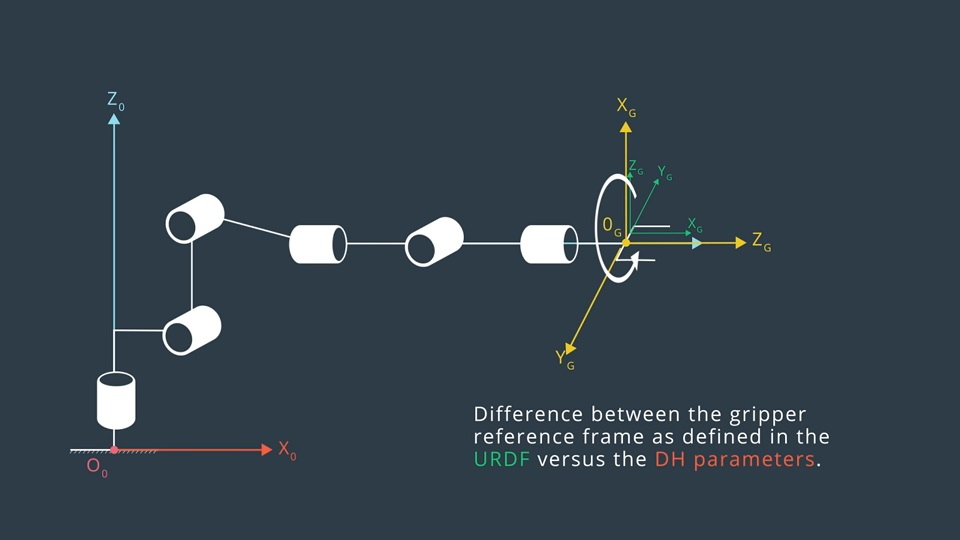

In [10]:
Image("img/total-transform-corretion.jpg")

So, we need to correct T0_G transform by rotating by pi along Z, and then by -pi/2 along Y.

$T_total = T0_G*rot_z(pi)*rot_y(-pi/2)$

In [11]:
def rot_x(q):
    r_x = Matrix([[ 1,      0,       0],
                  [ 0, cos(q), -sin(q)],
                  [ 0, sin(q),  cos(q)]])
    return r_x


def rot_y(q):
    r_y = Matrix([[  cos(q), 0, sin(q)],
                  [       0, 1,      0],
                  [ -sin(q), 0, cos(q)]])
    return r_y


def rot_z(q):
    r_z = Matrix([[ cos(q), -sin(q), 0],
                  [ sin(q),  cos(q), 0],
                  [      0,       0, 1]])
    return r_z

#compensate
R_corr = Matrix(simplify(rot_z(pi) * rot_y(-pi/2)))

# Compute complete transform
T_corr = R_corr.row_insert(3, Matrix([[0, 0, 0]]))
T_corr = T_corr.col_insert(3, Matrix([0, 0, 0, 1]))

T_total = T0_G*T_corr

### TESTING

In [12]:
import numpy as np

# Radians to Degree
def rtod(q):
    return q*180.0/np.pi

# Degree to Radians
def dtor(q):
    return q*np.pi/180.0

#generate random joint values
def generateRandomInRange(low, high):
    return low + np.random.rand()*(high - low)

q1 = generateRandomInRange(dtor(-185), dtor(185))
q2 = generateRandomInRange(dtor(-45), dtor(85))
q3 = generateRandomInRange(dtor(-210), dtor(155-90))
q4 = generateRandomInRange(dtor(-350), dtor(350))
q5 = generateRandomInRange(dtor(-125), dtor(125))
q6 = generateRandomInRange(dtor(-350), dtor(350))

DH = {alpha0: 0,      a0: 0,      d1: 0.75,     q1: q1,
      alpha1: -pi/2,  a1: 0.35,   d2: 0, 	    q2: q2-pi/2,
      alpha2: 0,      a2: 1.25,   d3: 0,	    q3: q3,
      alpha3: -pi/2,  a3: 0.0536, d4: 1.5014,   q4: q4,
      alpha4: pi/2,   a4: 0,      d5: 0,	    q5: q5,
      alpha5: -pi/2,  a5: 0,      d6: 0,        q6: q6,
      alpha6: 0,      a6: 0,      d7: 0.303,    q7: 0}

T0_1 = homogeneous_transform(q1, d1, a0, alpha0).subs(DH)
T1_2 = homogeneous_transform(q2, d2, a1, alpha1).subs(DH)
T2_3 = homogeneous_transform(q3, d3, a2, alpha2).subs(DH)
T3_4 = homogeneous_transform(q4, d4, a3, alpha3).subs(DH)
T4_5 = homogeneous_transform(q5, d5, a4, alpha4).subs(DH)
T5_6 = homogeneous_transform(q6, d6, a5, alpha5).subs(DH)
T6_G = homogeneous_transform(q7, d7, a6, alpha6).subs(DH)

# Extract rotation matrices from the transformation matrices
# Generalized homogeneous transform
# remember to correct the difference between DH and ROS
T0_G = T0_1 * T1_2 * T2_3 * T3_4 * T4_5 * T5_6 * T6_G
T0_G_rpy = T0_G * T_corr

print(T0_G_rpy)

Matrix([[0.748731673875067, -0.0216964289692733, -0.662518034098863, -2.10097336654362], [0.257871152178367, 0.930269161614108, 0.260963131158382, 1.20215219101467], [0.610658128096599, -0.366235650803914, 0.702116869666149, 2.45034593579355], [0, 0, 0, 1]])


# INVERSE KINEMATICS

Suppose this is are the desired poses of the end effector 

In [13]:
from geometry_msgs.msg import Pose
from trajectory_msgs.msg import JointTrajectoryPoint
import tf

############ ROS SERVICE SIMULATION############
class request_simple():
    def __init__(self):
        self.poses = [Pose()]
        self.poses[0].position.x = 1
        self.poses[0].position.y = 1
        self.poses[0].position.z = 1
###############################################

req = request_simple()

for x in xrange(0, len(req.poses)):
    # IK code starts here
    joint_trajectory_point = JointTrajectoryPoint()

    # Extract end-effector position and orientation from request
    # px,py,pz = end-effector position
    # roll, pitch, yaw = end-effector orientation
    px = req.poses[x].position.x
    py = req.poses[x].position.y
    pz = req.poses[x].position.z

    (roll, pitch, yaw) = tf.transformations.euler_from_quaternion(
                            [req.poses[x].orientation.x, req.poses[x].orientation.y,
                            req.poses[x].orientation.z, req.poses[x].orientation.w])

Given End effector position and orientation, we calculate the the wrist center as follows, this equation calculates the wrist center by applying a translation on the opposite direction of the gripper (translation on z axis):

The last three joints q4, q5, q6 don't affect the position of Wrist Center(O5), hereby referred to as WC position.(this can be confirmed by running the Forward kinematics demo.) This is very convenient for us in decoupling the IK problem into a position and orientation problem where we can first compute the position of the WC(which gives us the first three joint angles q1, q2, q3) and orientation of the wrist , which gives us the last three joints q4, q5, q6. Detailed explanation follows, 

In [14]:
# Calculate joint angles using Geometric IK method
# Calculating the Rotation Matrix for the Gripper
r, p, y = symbols('r p y')
R_x = rot_x(r)
R_y = rot_y(p)
R_z = rot_z(y)

Rrpy = R_z * R_y * R_x * R_corr

Rrpy = Rrpy.subs({'r': roll, 'p': pitch, 'y': yaw})

# Calculate the wrist center position
nx = Rrpy[0,2]
ny = Rrpy[1,2]
nz = Rrpy[2,2]

# d7: 0.303
wx =  px - 0.303 * nx
wy =  py - 0.303 * ny
wz =  pz - 0.303 * nz

Once the wrist center (WC) is known we can calculate the first joint angle with a simple arctangent:

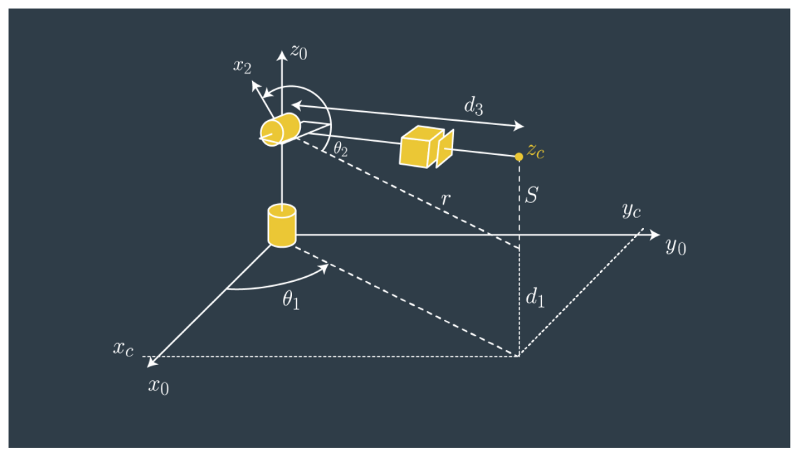

In [15]:
Image("img/ik_1.png")

In [16]:
# Theta 1 from above is a simple atan2
theta1 = atan2(wy, wx)
# Calculate Radius from above
r = sqrt(wx**2+wy**2) - 0.35 # a1: 0.35

print(theta1)
print(r)

0.962086624207346
0.868937652220162


We can calculate the nwxt joints positions with the law of cosines. 
In trigonometry, the law of cosines (also known as the cosine formula or cosine rule) relates the lengths of the sides of a triangle to the cosine of one of its angles, the law of cosines states: 
$c^2 = a^2 +b^2 -2ab*cos(γ)$

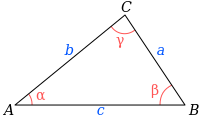

In [17]:
Image("img/eq4.png")

In [18]:
# Calculating Theta 2 and 3 using cosine law. A, B and C are sides of the triangle
A = 1.5014 # d4
B = sqrt(r**2+(wz-0.75)**2) # d1: 0.75
C = 1.25 # a2

# a corresponds to angle alpha
a = acos((B**2 + C**2 - A**2) / (2*B*C))
theta2 = pi/2 - a - atan2(wz-0.75, r) # d1: 0.75

# b corresponds to angle beta
b = acos((A**2 + C**2 - B**2) / (2*A*C))
theta3 = pi/2 - (b + 0.036)

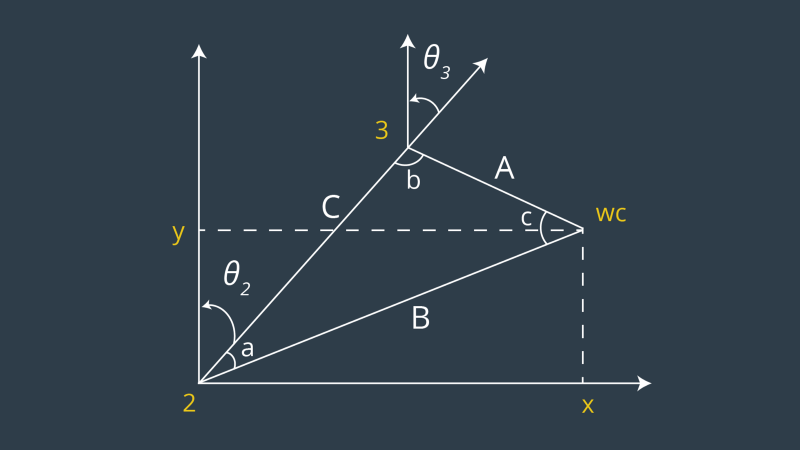

In [19]:
Image("img/triangle.png")

### Inverse Orientation Kinematics

Now, we need to calculate q4, q5, q6. For this we calculate the rotation matrix R3_6 from our total transform and calculated angles numerically(from end effector position/rotation) and symbolically(from DH parameters). We then compare the two representations to calculate plausible values of the last three joint angles.

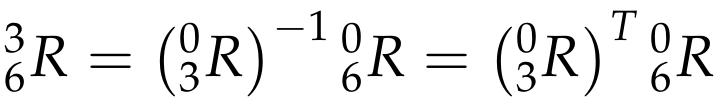

In [20]:
Image("img/eq5.png")

In [21]:
T0_3 = T0_1 * T1_2 * T2_3

R0_3 = T0_3[0:3,0:3]
R0_G = Rrpy # THIS IS OUR TARGET ORIENTATION!
R3_6 = R0_3.transpose() * R0_G # NO NEED TO COMPENSATE BECOUSE R0_G already was multiplicated by R_CORR
R3_6 = R3_6.subs({q1: theta1, q2:theta2, q3: theta3})

In [22]:
theta5 = atan2(sqrt(R3_6[0,2]**2 + R3_6[2,2]**2), R3_6[1,2])
# Choosing between multiple possible solutions:
if sin(theta5) < 0:
    theta4 = atan2(-R3_6[2,2], R3_6[0,2])
    theta6 = atan2(R3_6[1,1], -R3_6[1,0])
else:
    theta4 = atan2(R3_6[2,2], -R3_6[0,2])
    theta6 = atan2(-R3_6[1,1], R3_6[1,0])

In [23]:
print("Computed IK: \n" +
       "\t q1: " + str(rtod(theta1.evalf())) + "\n" +
       "\t q2: " + str(rtod(theta2.evalf())) + "\n" +
       "\t q3: " + str(rtod(theta3.evalf())) + "\n" +
       "\t q4: " + str(rtod(theta4.evalf())) + "\n" +
       "\t q5: " + str(rtod(theta5.evalf())) + "\n" +
       "\t q6: " + str(rtod(theta6.evalf())) + "\n")

Computed IK: 
	 q1: 55.1235030930698
	 q2: -12.8593569703425
	 q3: 50.9746771997817
	 q4: -144.323309505103
	 q5: 131.792264934950
	 q6: 25.5696624406453



Sources:

   1. https://en.wikipedia.org/wiki/Denavit%E2%80%93Hartenberg_parameters
    
   2. https://github.com/udacity/RoboND-Kinematics-Project
    
   3. https://nitishpuri.github.io/posts/robotics/inverse-kinematics-on-kuka-arm-using-ros-and-python/
    
   4. https://medium.com/@fernandojaruchenunes/udacity-robotics-nd-project-2-robotic-arm-pick-place-71af9c9ba519